# Import Data Files

Here we will upload and/or search for the CSV file we want. If it cannot be found, we will ask to upload the file.

In [1]:
from google.colab import files
from os.path import exists

if not exists("Restaurants.csv"):
  print("Please upload the data file in CSV format:")
  uploaded = files.upload()
else:
  print("Data file of type CSV found")

Data file of type CSV found


# Read and Clean Data

Next, we will read the CSV file and create our main dataframe.

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

data = pd.read_csv("Restaurants.csv")
data = data[["Name", "Type", "Street Address", "Location", "Contact Number", "Comments", "Reviews", "No of Reviews"]]

Remove null values for Type and No of Reviews, as our primary source of filtering in the final view will be by the number of reviews. We also fill ```None``` Comments with a blank string and convert the Number of Reviews column to an ```int```

In [3]:
data = data.dropna(subset=["Type", "No of Reviews"])
data.Comments = data.Comments.fillna("")
data["No of Reviews"] = data["No of Reviews"].str.replace("[reviews,]","", regex=True)
data["No of Reviews"] = data["No of Reviews"].str.strip()
data = data.astype({"No of Reviews":"int"})

Remove the ZIP Code (and any trailing spaces) from the Location for easier processing. This will also check for and remove any Location data that does not contain a US state.

In [4]:
data.Location = data.Location.str.replace('[0123456789-]', '', regex=True)
data.Location = data.Location.str.rstrip()
state_values = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
data = data[data.Location.str.contains("|".join(state_values))]

Sample of the data after the necessary cleaning

In [5]:
data.sample(5)

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews
1644,Youngblood's Cafe,"American, Cafe, Grill",620 SW 16th Ave,"Amarillo, TX",+1 806-342-9411,Why go to a chain restaurant when their are so...,4.5 of 5 bubbles,128
1809,Sunset Pizza & Pasta,"Italian, Pizza, Vegetarian Friendly",16711 Pacific Ave,"Huntington Beach, CA",+1 562-592-1133,,4.5 of 5 bubbles,75
1417,Francesca's Cucina,"Italian, Vegetarian Friendly, Vegan Options",545 N Salina St,"Syracuse, NY",+1 315-425-1556,Excellent Italian restaurant boasting creative...,4.5 of 5 bubbles,585
784,Jimmy Mac's Roadhouse,"American, Steakhouse, Bar",34902 Pacific Hwy S,"Federal Way, WA",+1 253-874-6000,"The first time we went, the service was horrib...",4 of 5 bubbles,203
198,15 Church Restaurant,"American, Vegetarian Friendly, Vegan Options",15 Church St,"Saratoga Springs, NY",+1 518-587-1515,"My husband and I absolutely love the food, the...",4.5 of 5 bubbles,821


# Visualize the Data

For data visualizations, we will use the ```seaborn``` library.

In [6]:
import seaborn as sb

Our first visualization is a ```histplot``` comparing the amount of reviews per state

<Axes: xlabel='Location', ylabel='Count'>

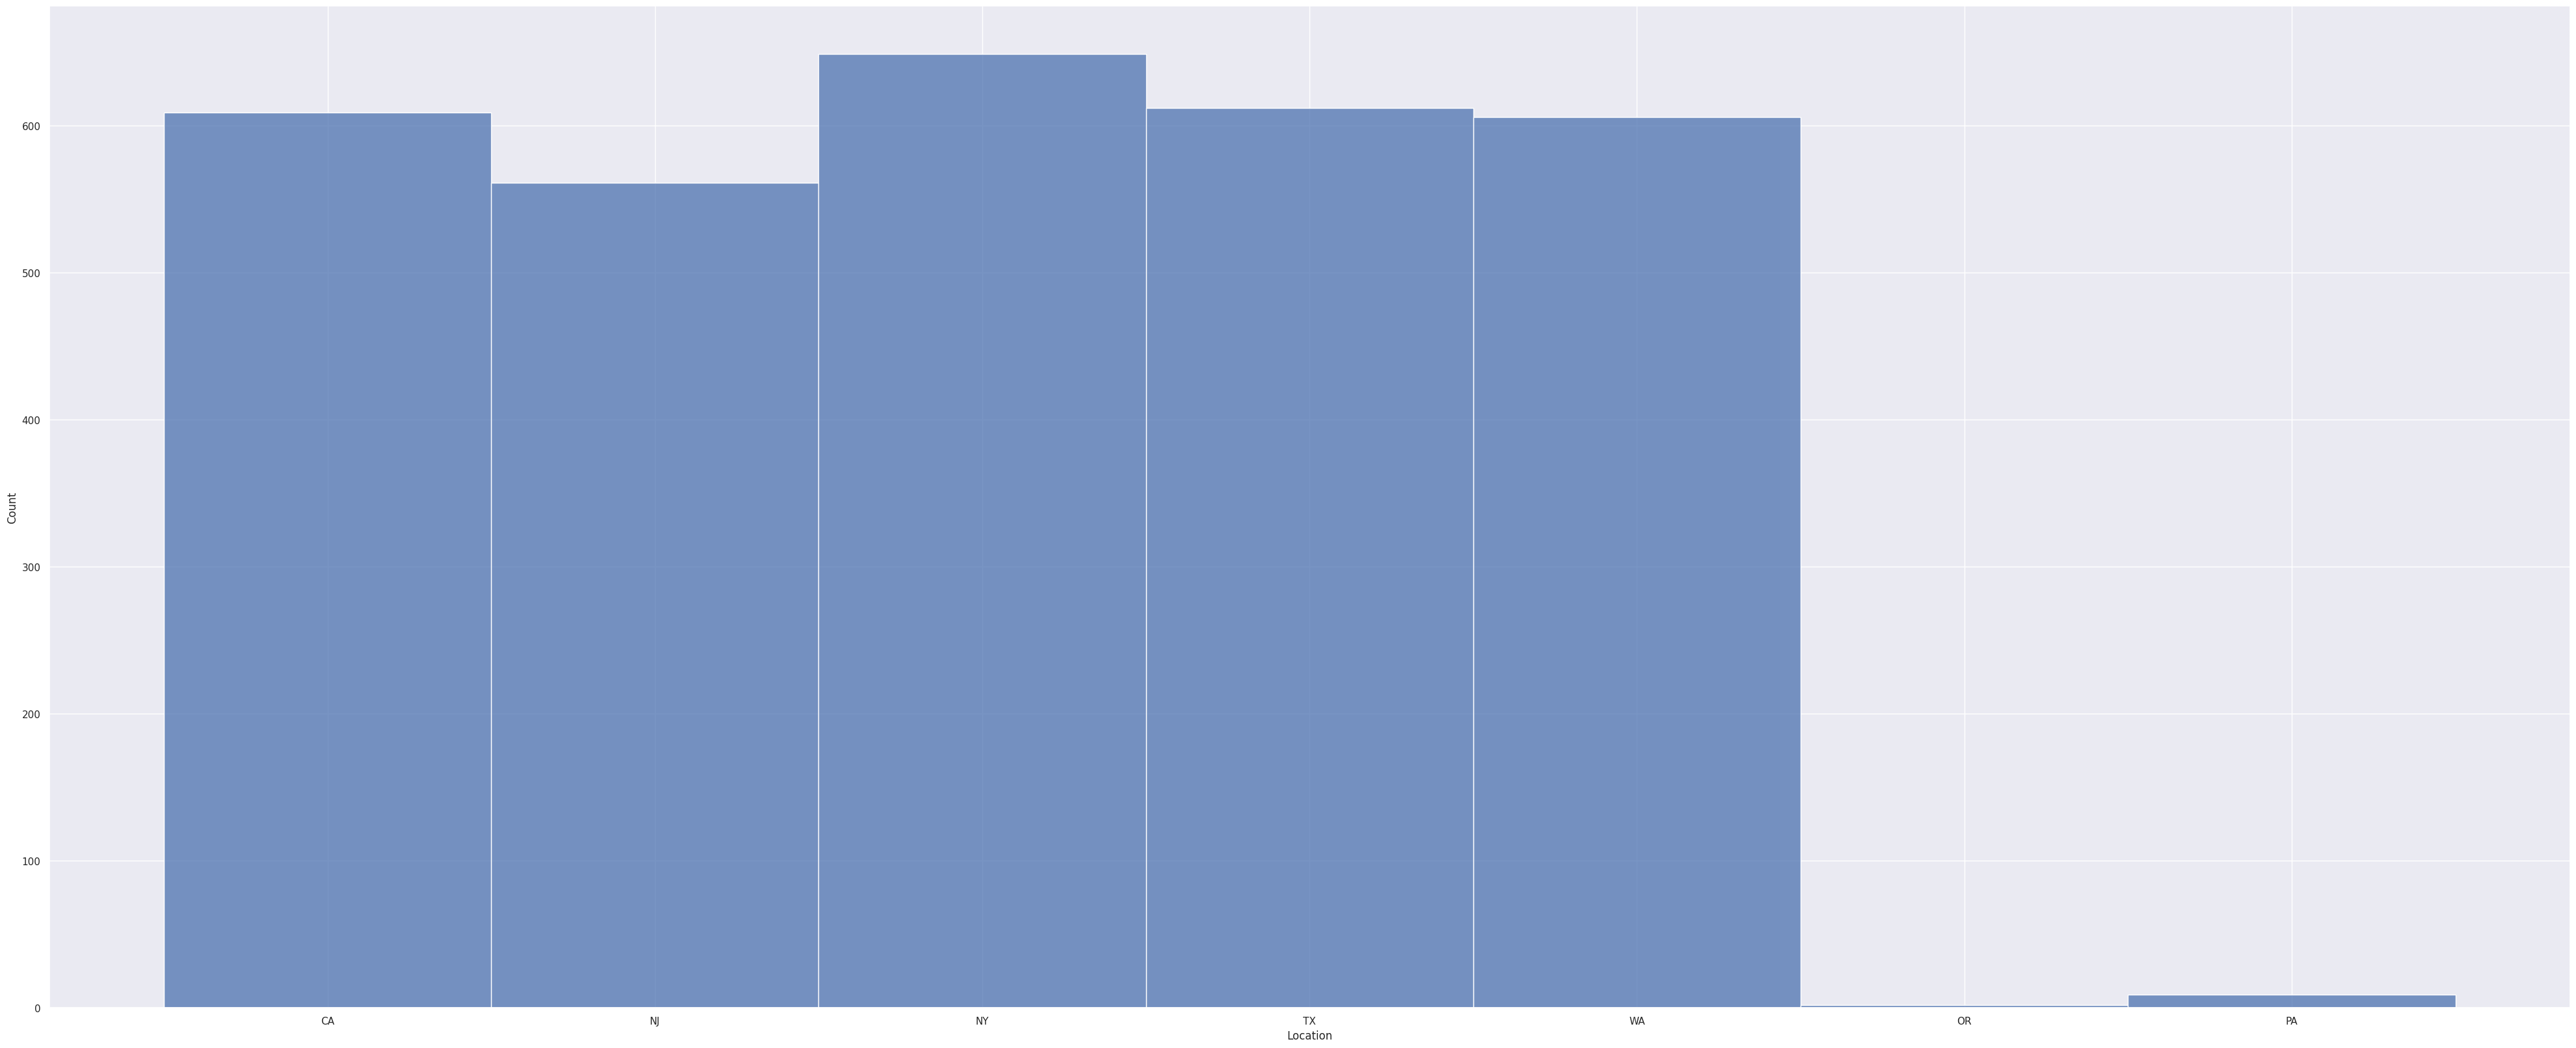

In [7]:
data_state = data.Location.str.slice(-2)
sb.set(rc={'figure.figsize':(50,20)})
sb.histplot(x=data_state, data=data_state)

The second visualization is a ```countplot``` to compare the number of reviews  versus the top 50 types of food categories, ordered in a descending manner from the highest frequency

(click to expand view of plot)

<Axes: xlabel='Type', ylabel='count'>

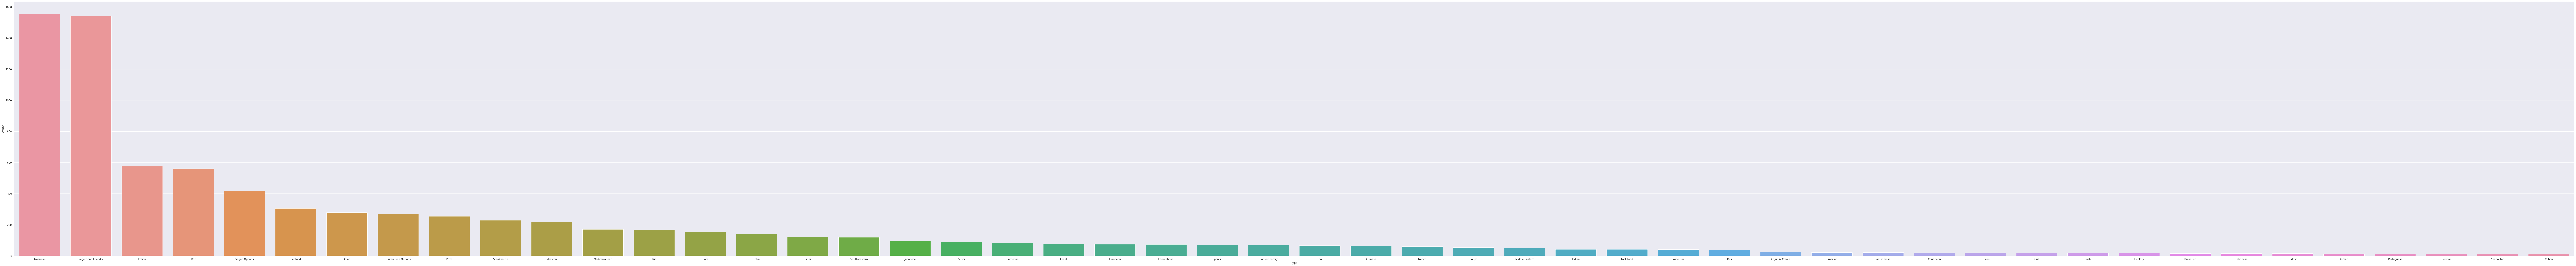

In [8]:
data_type = data.Type.str.split(pat=",")
data_type = data_type.explode("Type")
data_type = data_type.str.lstrip()

sb.set(rc={'figure.figsize':(200,20)})
sb.countplot(x=data_type, data=data_type, order=data_type.value_counts().iloc[:50].index)

The last visualization is a ```pieplot``` using the library included in ```pandas``` utilizing matpotlib. Here we have created a chart to show how many of a certain review rating is present.

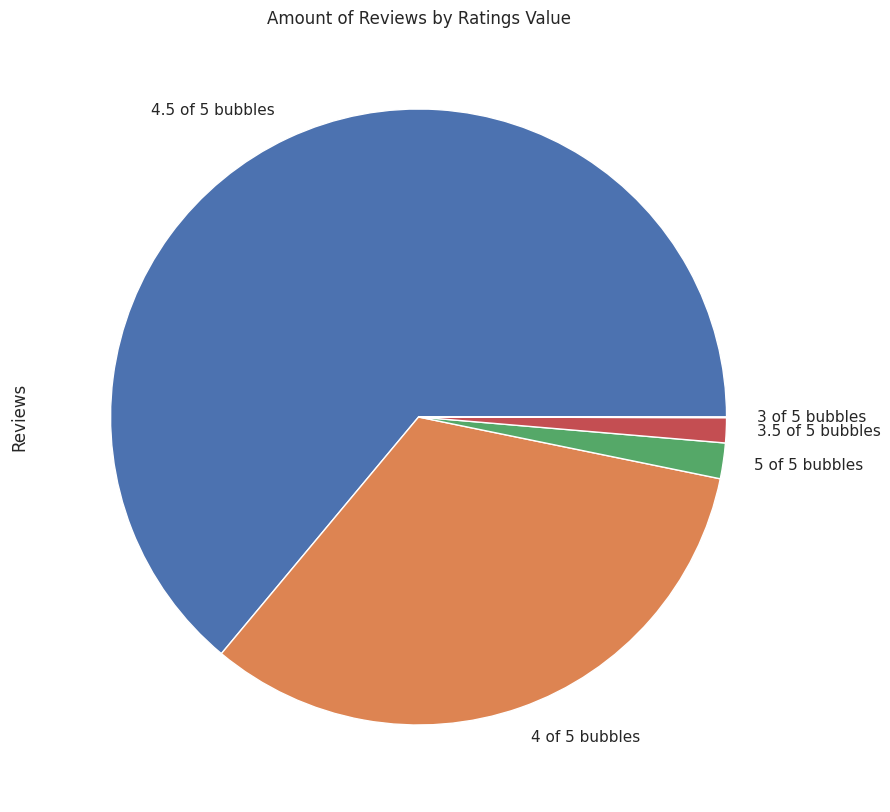

In [9]:
data_reviews = data.Reviews.value_counts()
plot = data_reviews.plot.pie(figsize=(10,10), title="Amount of Reviews by Ratings Value")

# Components of Recommendation Model

Processing stage of data to remove duplicates by Name and combine comments from duplicate name rows

In [10]:
group = data.groupby("Name")
data = group.agg("first")
data.update(group.agg({"Comments" : lambda x: list(x.astype(str))}))
data.reset_index(inplace=True)

Since our model will be utilizing a Location (city) and a Type, we will filter for either and return results based on the input.

In [11]:
import numpy as np
import pandas as pd
import re

def filter_data(location=None, rest_type=None):
  if location is not None:
    location_mask = data.Location.str.contains(location)
    data_filtered = data.query("@location_mask")
  else:
    data_filtered = data  
  if rest_type is not None:
    type_mask = data.Type.str.contains(rest_type)
    data_filtered = data_filtered.query("@type_mask")
  else:
    data_filtered = data_filtered
  return data_filtered

Example output using ```Dallas``` for a Location

In [12]:
filter_data("Dallas").sample(5)

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews
1462,Mia's Tex Mex,"Mexican, Southwestern, Vegetarian Friendly",4322 Lemmon Ave,"Dallas, TX",+1 214-526-1020,"[Always the best and my favorite, both when I ...",4.5 of 5 bubbles,252
1263,Lavendou,"French, Vegetarian Friendly, Vegan Options",19009 Preston Rd,"Dallas, TX",+1 972-248-1911,[Have brought my clients here several times an...,4.5 of 5 bubbles,264
2338,The Slow Bone,"American, Barbecue",2234 Irving Blvd,"Dallas, TX",+1 214-377-7727,[I love BBQ. A friend of mine recommened Slow...,4.5 of 5 bubbles,236
697,E Bar Tex-Mex,"Mexican, Southwestern, Vegetarian Friendly",1901 N Haskell Ave Ste 120,"Dallas, TX",+1 214-824-3227,[We came after the lunch rush ended and were i...,4.5 of 5 bubbles,185
2579,Y.O. Ranch Steakhouse,"Seafood, American, Steakhouse",702 Ross Ave,"Dallas, TX",+1 214-744-3287,[Non-chain true Texas style steak house. The N...,4.5 of 5 bubbles,1201


Example output using ```Seafood``` as an input for Type

In [13]:
filter_data(rest_type="Seafood").sample(5)

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews
1569,Ocean City's Island Grill Seafood & Steak House,"American, Seafood, Gluten Free Options",Corner of 1st. & Atlantic Ave.,"Ocean City, NJ",+1 609-391-9616,[Consistently above expectations. Early Bird i...,4 of 5 bubbles,263
289,Black Whale Bar & Fish House,"American, Bar, Seafood",100 N Pennsylvania Ave,"Beach Haven, Long Beach Island, NJ",+1 609-492-0025,[We were able to stop in for Bloody Marys and ...,4 of 5 bubbles,469
1833,Restaurant at Engleside Inn,"American, Seafood, Sushi",30 Engleside Ave,"Beach Haven, Long Beach Island, NJ",+1 800-762-2214,[Always been one of my favourite place for din...,4.5 of 5 bubbles,211
462,Catfish Charlie's,"American, Seafood",5830 McArdle Rd Ste 12,"Corpus Christi, TX",+1 361-993-0363,[Catfish Charlie’s has survived for many years...,4.5 of 5 bubbles,379
820,Fish Shack,"American, Seafood",700 E 15th St,"Plano, TX",469-229-0838,[The fried oysters are legit delicious. Son an...,4.5 of 5 bubbles,332


And finally, example data using both inputs

In [14]:
filter_data("Dallas", "Seafood").sample(5)

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews
1903,S & D Oyster Co,"American, Seafood",2701 McKinney Ave,"Dallas, TX",+1 214-880-0111,[We’ve been here numerous times over the years...,4.5 of 5 bubbles,253
2579,Y.O. Ranch Steakhouse,"Seafood, American, Steakhouse",702 Ross Ave,"Dallas, TX",+1 214-744-3287,[Non-chain true Texas style steak house. The N...,4.5 of 5 bubbles,1201
2440,"Truluck's Seafood, Steak, and Crab House","Steakhouse, American, Seafood",2401 McKinney Ave,"Dallas, TX",+1 214-220-2401,[This was our first visit to Truluck's on McKi...,4.5 of 5 bubbles,876
1570,Ocean Prime,"American, Seafood, Vegetarian Friendly",2101 Cedar Springs Rd,"Dallas, TX",+1 214-965-0440,[We planned to have dinner here. We ordered ap...,4.5 of 5 bubbles,382
1027,III Forks,"Seafood, American, Steakhouse",17776 Dallas Pkwy,"Dallas, TX",+1 972-267-1776,[My husband and I celebrated both Valentine's ...,4.5 of 5 bubbles,487


Use ```NLTK-Rake``` for Comment keyword extraction, adding it into an extra column at the end of the main dataframe

In [ ]:
!pip install rake_nltk
import nltk
nltk.download('popular')
nltk.download('stopwords')
from rake_nltk import Rake

r = Rake()

def text_raker(x, r):
  r.extract_keywords_from_sentences(x)
  return r.get_ranked_phrases()[0:3]

def comment_extractor(data):
  data["Popular Key Phrases"] = data["Comments"].apply(lambda x: text_raker(x, r))

Sample of the data once the comment extractor has been run

In [16]:
comment_extractor(data)
data.sample(5)

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews,Popular Key Phrases
1676,Pecan Grill at the Overton Hotel,"American, Southwestern, Bar",2322 Mac Davis Ln,"Lubbock, TX",+1 806-776-7010,[Everything was just the way we wanted it. Roo...,4.5 of 5 bubbles,417,"[warmer days, room could, way]"
1819,Red House Beer & Wine Shoppe,"American, Wine Bar, Vegetarian Friendly",410 Burnett Ave S,"Renton, WA",+1 425-226-2666,[Cute little gem tucked into downtown Renton. ...,4.5 of 5 bubbles,234,"[cute little gem tucked, last visit ..., exten..."
1051,Island Cafe,"American, Bar, Cafe",250 NE Tomahawk Island Dr,"Portland, OR",+1 503-283-0362,[This place is wonderful. We tried it for the ...,4.5 of 5 bubbles,269,"[went specifically ..., first time late, pacif..."
1865,Rodeo Goat,"American, Bar, Vegetarian Friendly",2636 Bledsoe,"Fort Worth, TX",817-877-4628,[The Rodeo Goat has a large patio. The burger...,4.5 of 5 bubbles,694,"[several different ones, rodeo goat, old fashion]"
1915,Saint Martin's Wine Bistro,"French, European, Wine Bar",3020 Greenville Ave,"Dallas, TX",+1 214-826-0940,[This is as close to being in France that you ...,4.5 of 5 bubbles,279,"[several french cuisine classics, americans st..."


Here is the main component of the recommendation system. 

We will pass in two ```str``` values which will then be entered into the ```filter_data``` function, and return a statement if the Dataframe is empty.
From here we will re-run the comment extractor and sort by the highest Number of Reviews.

Afterwards, we will create a matrix of the ```Type``` value and use ```cosine_similarity``` against the ```Name``` at the first index, or the result with the highest amount of Reviews.

Finally, we will return the top 10 (if there are more than 10 results) from the given restaurant.

In [17]:
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity

def restaurant_recommendation(location=None, rest_type=None):
  
  data_filtered = filter_data(location,rest_type)
  if data_filtered.empty:
    print ("Sorry, that food type has not been found in", location,
           "\nHere are other restaurants in that City")
    data_filtered = filter_data(location)
  comment_extractor(data_filtered)
  data_filtered = data_filtered.sort_values(by="No of Reviews", ascending=False).reset_index(drop = True)
  
  matrix = data_filtered["Type"].tolist()
  tfidf = text.TfidfVectorizer(stop_words="english")
  type_matrix = tfidf.fit_transform(matrix)
  similar = cosine_similarity(type_matrix)
  indices = pd.Series(data_filtered.index, index=data_filtered.Name)
  
  index = indices[0]
  rest_similar = list(enumerate(similar[index]))
  rest_similar = sorted(rest_similar, key=lambda x:x[1], reverse=True)
  rest_similar = rest_similar[0:10]
  rest_indices = [i[0] for i in rest_similar]

  return data_filtered.iloc[rest_indices]

A Sample using ```"Dallas, TX"``` as the ```location```

In [18]:
restaurant_recommendation(location="Dallas, TX")

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews,Popular Key Phrases
0,Pappas Bros. Steakhouse,"American, Steakhouse, Vegetarian Friendly",10477 Lombardy Ln,"Dallas, TX",+1 214-366-2000,"[Service, ambiance, available wine and drinks ...",4.5 of 5 bubbles,1548,"[took two international clients, one blowout m..."
7,Al Biernat's,"American, Steakhouse, Vegetarian Friendly",4217 Oak Lawn Ave,"Dallas, TX",+1 214-219-2201,[Al Biernat’s never fails to give a great expe...,4.5 of 5 bubbles,776,"[totally best service ever, al biernat ’, some..."
3,Y.O. Ranch Steakhouse,"Seafood, American, Steakhouse",702 Ross Ave,"Dallas, TX",+1 214-744-3287,[Non-chain true Texas style steak house. The N...,4.5 of 5 bubbles,1201,"[chain true texas style steak house, chicken f..."
6,"Truluck's Seafood, Steak, and Crab House","Steakhouse, American, Seafood",2401 McKinney Ave,"Dallas, TX",+1 214-220-2401,[This was our first visit to Truluck's on McKi...,4.5 of 5 bubbles,876,"[super sight lines, second floor booth, withou..."
9,III Forks,"Seafood, American, Steakhouse",17776 Dallas Pkwy,"Dallas, TX",+1 972-267-1776,[My husband and I celebrated both Valentine's ...,4.5 of 5 bubbles,487,"[15 minutes early, wedding anniversary, wait ...."
1,Kenny's Wood Fired Grill,"American, Bar, Vegetarian Friendly",5000 Belt Line Rd Ste 775,"Dallas, TX",+1 972-392-9663,[My first time here but won't be my last! Food...,4.5 of 5 bubbles,1406,"[worth ..., worth ..., next trip]"
2,Gas Monkey Bar N' Grill,"American, Bar, Vegetarian Friendly",10261 Technology Blvd E,"Dallas, TX",+1 214-350-1904,[We always have a great time at Gas Monkey! Th...,4 of 5 bubbles,1223,"[area gas monkey live, gas monkey garage, 2 bl..."
13,Ocean Prime,"American, Seafood, Vegetarian Friendly",2101 Cedar Springs Rd,"Dallas, TX",+1 214-965-0440,[We planned to have dinner here. We ordered ap...,4.5 of 5 bubbles,382,"[seafood restaurant, nothing special, go elsew..."
22,Cafe 43,"American, Cafe, Vegetarian Friendly",George W. Bush Presidential Library,"Dallas, TX",+1 214-200-4302,[We went to Cafe 43 for our 44th anniversary t...,4.5 of 5 bubbles,263,"[chocolate tres leches cake, great last year, ..."
10,Eatzi's Market & Bakery,"American, Vegetarian Friendly, Vegan Options",3403 Oak Lawn Ave,"Dallas, TX",+1 214-526-1515,[this is a very unusual place to get great foo...,4.5 of 5 bubbles,453,"[get great food, unusual place, bread etc]"


And another sample where we are only passing in ```"Seafood"``` as the ```rest_type```

In [19]:
restaurant_recommendation(rest_type="Seafood")

,Name,Type,Street Address,Location,Contact Number,Comments,Reviews,No of Reviews,Popular Key Phrases
0,Eddie V's Prime Seafood,"American, Seafood, Vegetarian Friendly",301 E 5th St,"Austin, TX",+1 512-472-1860,[Our hotel had called and made our reservation...,4.5 of 5 bubbles,2282,"[fine restaurant several times, happy hour pla..."
5,Dock's Oyster House,"American, Seafood, Vegetarian Friendly",2405 Atlantic Ave,"Atlantic City, NJ",+1 609-345-0092,[Dock’s Oyster House is a MUST restaurant for...,4.5 of 5 bubbles,1599,"[123 year old family owned establishment, vale..."
6,Pacifica Seafood Restaurant,"American, Seafood, Vegetarian Friendly",73505 El Paseo,"Palm Desert, Greater Palm Springs, CA",+1 760-674-8666,[],4.5 of 5 bubbles,1540,[]
11,"Truluck's Seafood, Steak, and Crabhouse","American, Seafood, Vegetarian Friendly",400 Colorado St,"Austin, TX",+1 512-482-9000,[The attention to detail and the ambiance make...,4.5 of 5 bubbles,1182,"[florida crab claws, wedge salad, scallops dish]"
12,Salty's On The Columbia River,"American, Seafood, Vegetarian Friendly",3839 NE Marine Dr,"Portland, OR",+1 503-288-4444,[Great views. Service was excellent. The food...,4.5 of 5 bubbles,1140,"[valentines day, still great, high quality]"
14,Clinkerdagger,"American, Seafood, Vegetarian Friendly",West 621 Mallon Street,"Spokane, WA",+1 509-328-5965,[We reserved a table for Valentine's Day dinne...,4.5 of 5 bubbles,1100,"[wife ordered maine lobster tail, ordered file..."
16,Sea Fire Grill,"American, Seafood, Vegetarian Friendly",158 E 48th St,"New York City, NY",+1 212-935-3785,[My husband brought me here for my birthday. ...,4.5 of 5 bubbles,1088,"[server benson provided us, server benson prov..."
17,Blue Plate Oysterette,"American, Seafood, Vegetarian Friendly",1355 Ocean Ave,"Santa Monica, CA",+1 310-576-3474,[],4.5 of 5 bubbles,987,[]
19,Shuckers Oyster Bar,"American, Seafood, Vegetarian Friendly",411 University St,"Seattle, WA",+1 206-621-1700,[we stayed at the fairmont so used this one ni...,4.5 of 5 bubbles,973,"[reading speakeasy recipes )., pretty good fai..."
21,Ivar's Mukilteo Landing,"American, Seafood, Vegetarian Friendly",710 Front St,"Mukilteo, WA",+1 425-742-6180,[Visited twice. Once in summer on the patio; t...,4.5 of 5 bubbles,966,"[“ foodies ”, consistently good although, wind..."


# Recommendation Model Widget

This is an interactive widget that will allow a search using the given dropdowns that populate from the data provided within the original CSV.

Please be sure to run ALL cells as there are dependencies on previous Dataframes.

In [20]:
import os
import ipywidgets as widgets
from IPython.display import display
from google.colab import output

city_input = widgets.Dropdown(
    options = data.sort_values(by="Location").Location.unique(),
                            description="City Name", value=None)

rest_type_input = widgets.Dropdown(
    options = data_type.sort_values().unique(), 
    description="Type", value=None)

rec_starter = widgets.Button(description="Find Restaurants")
clear_button = widgets.Button(description="Clear Dropdowns")
clear_output_button = widgets.Button(description="Clear Output")

rest_recommendation = widgets.Output()

def widget_input(input_change):
  with rest_recommendation:
    rec_starter.on_click(callback=button_clicked)
    clear_button.on_click(callback=clear_dropdowns)
    clear_output_button.on_click(callback=clear_output)

def button_clicked(click):
    display(restaurant_recommendation(
        city_input.value,
        rest_type_input.value))
    
def clear_output(click):
  output.clear()
  display(city_input, rest_type_input, rec_starter,
          clear_button, clear_output_button) 

def clear_dropdowns(click):
  rest_type_input.value = None
  city_input.value = None 

city_input.observe(widget_input, names="value")
rest_type_input.observe(widget_input, names="value")

display(city_input, rest_type_input, rec_starter,
        clear_button, clear_output_button)

Dropdown(description='City Name', index=26, options=('Addison, TX', 'Alameda, CA', 'Albany, NY', 'Amarillo, TX…

Dropdown(description='Type', options=('Afghani', 'African', 'American', 'Argentinean', 'Armenian', 'Asian', 'A…

Button(description='Find Restaurants', style=ButtonStyle())

Button(description='Clear Dropdowns', style=ButtonStyle())

Button(description='Clear Output', style=ButtonStyle())